## `unique-consecutive`
Which is the fastes way to achieve something like PyTorch's `torch.unique_consecutive`? [link](https://pytorch.org/docs/stable/generated/torch.unique_consecutive.html#torch.unique_consecutive)

In [1]:
import numpy as np
import numba as nb
import dask.array as da

from plot_machinery.plot import data, kernel, plot, repeat_count, clear_kernels

In [16]:
clear_kernels()

@kernel()
def unique(x, missing_value):
    return np.unique(x)


@kernel()
def compare_with_left_neighbor(x, missing_value):
    shifted = np.concatenate((x[1:], [missing_value]))
    mask = x != shifted
    return x[mask]


@kernel()
def compare_with_right_neighbor(x, missing_value):
    shifted = np.concatenate(([missing_value], x[:-1]))
    mask = x != shifted
    return x[mask]

@kernel()
@nb.jit(nopython=True, fastmath=True, cache=True, nogil=True)
def numba_loop(x, missing_value):
    x_size = len(x)
    y = np.empty(x_size + 1, dtype=x.dtype)
    y[0] = x[0]
    
    x = np.concatenate((x, np.array([missing_value])))
    
    x_prev = x[0]
    x_i = x[1]
    
    curr_write = 1
    curr_read = 1
    while curr_read < x_size:
        while x_prev == x_i:
            curr_read += 1
            x_i = x[curr_read]
        y[curr_write] = x_i
        curr_write += 1
        x_prev = x_i
    return y[:curr_write-1]


@nb.jit(nopython=True, fastmath=True, cache=True, nogil=True)
def _numba_loop_dask(x, missing_value):
    x_size = len(x) - 2
    y = np.empty(x_size + 1, dtype=x.dtype)

    x[-1] = missing_value
    x_prev = x[0]
    x_i = x[1]

    curr_write = 0
    curr_read = 1
    while curr_read < x_size + 1:
        while x_prev == x_i:
            curr_read += 1
            x_i = x[curr_read]
        y[curr_write] = x_i
        curr_write += 1
        x_prev = x_i
    return y[:curr_write-1]


@kernel()
def dask_map_overlap_1000(x, missing_value):
    x = da.from_array(x, chunks=1000)
    return x.map_overlap(_numba_loop_dask, missing_value=missing_value, depth=1, boundary=missing_value, 
                         dtype=x.dtype, meta=np.array(()), trim=False).compute()


@kernel()
def dask_map_overlap_10000(x, missing_value):
    x = da.from_array(x, chunks=10000)
    return x.map_overlap(_numba_loop_dask, missing_value=missing_value, depth=1, boundary=missing_value, 
                         dtype=x.dtype, meta=np.array(()), trim=False).compute()


@kernel()
def dask_map_overlap_100000(x, missing_value):
    x = da.from_array(x, chunks=100000)
    return x.map_overlap(_numba_loop_dask, missing_value=missing_value, depth=1, boundary=missing_value, 
                         dtype=x.dtype, meta=np.array(()), trim=False).compute()


@repeat_count
def count(step):
    return 1000 if step < 1000 else 100


@data(steps=[100, 1000, 10000, 100000, 1000000])
def data_gen(step):
    x = np.empty(step, dtype=int)
    for i in range(step // 10):
        x[i*10:(i+1)*10] = i
    return (x,10)

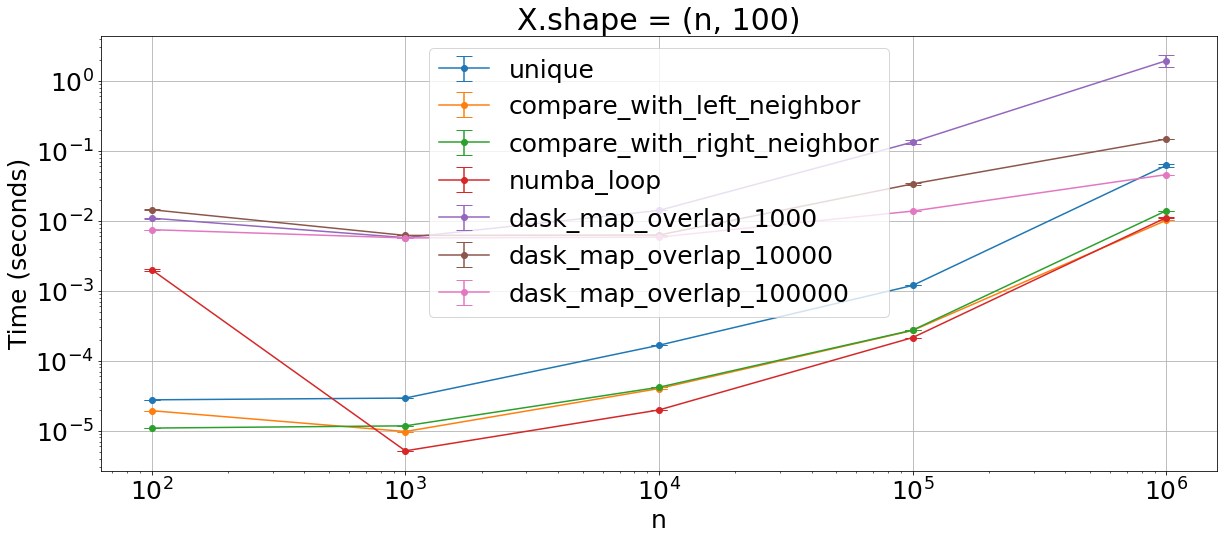

In [15]:
plot(logx=True, logy=True, xlabel="n", title="X.shape = (n, 100)")